# Engenharia do Conhecimento 2023/2024

## Decision Tree Modeling


### A simple tutorial created for machine learning courses @ DI/FCUL
(c) André Falcão - 2022-2024 + Cátia Pesquita + Sofia Teixeira + Nuno Garcia + Sara Silva


## Contents

* Concept of disorder and entropy
* Decision trees
     * Selection of variables
     * The ID3 algorithm
     * How to make predictions
* Exercises


## Introduction

This tutorial requires the following Python libraries to be installed:
* numpy
* pandas
* scikit-learn


## 1. The concept of disorder and entropy

The idea of building decision trees for machine learning is based on a partition of the space of variables and choosing the variable that allows an improvement in the existing "disorder" by subdivision, aiming, in a classification problem, to find the variable that best separates the classes of a problem.

The disorder of a system can be quantified by its [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)), which is defined by the following formula:

$Entropy=- \sum_i{p_i . \log_2{p_i}}$

where $p_i$ is the probability (or proportion) of each class $i$ within a given set of instances. In the case of two classes, entropy is maximum ($Entropy=1.0$) when each class is equally represented ($p_i=0.5$). If, on the other hand, there is only one class, then we have $Entropy=0.0$

We can define entropy with a function that takes a list of instances and calculates their probabilities and sum, using the `numpy` library:

In [16]:
import numpy as np
def entropy(y):
    values, counts = np.unique(y,return_counts=True)
    probs=counts/len(y)
    #print(counts, probs)
    return -np.sum(probs*np.log2(probs))


Imagining that we toss a coin several times in the air, let us calculate the entropy associated with the system:

In [17]:
from random import choices, seed
seed(42)
coin=choices(["Heads", "Tails"], k=10)
print(coin)
print("The entropy is:", entropy(coin))

['Tails', 'Heads', 'Heads', 'Heads', 'Tails', 'Tails', 'Tails', 'Heads', 'Heads', 'Heads']
The entropy is: 0.9709505944546686


On the other hand, if we only had "Heads" or only "Tails" the entropy would be zero, because we have a perfectly predictable system:

In [18]:
coin_head=["Head"]*10
coin_tail=["Tail"]*10
print(coin_head)
print(coin_tail)
print("The entropy is:", entropy(coin_head))
print("The entropy is:", entropy(coin_tail))

['Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head', 'Head']
['Tail', 'Tail', 'Tail', 'Tail', 'Tail', 'Tail', 'Tail', 'Tail', 'Tail', 'Tail']
The entropy is: -0.0
The entropy is: -0.0


## 2. Introduction to Decision Trees as Entropy Decreasing Strategies

In a decision tree, we want to find the best way to divide the multidimensional space of the problem so that the entropy is as small as possible on both sides of each choice.

Let's now take the example of a decision we would like to make in order to know whether to play tennis or not. [In this dataset](https://www.kaggle.com/fredericobreno/play-tennis) we have 4 environmental variables (*outlook, temp, humidity, wind*) and a dependent variable (*play*). Each line represents one day in the 14-day record in which we decided whether or not to play tennis according to the variables observed.

The goal is to understand the best way to divide the space to make the cases with `play="Yes"` separate from the cases with `play="No"`

Here we will use the pandas library for reading a text file and managing and presenting data through a dataframe.

In [19]:
import pandas as pd
tennis= pd.read_csv("tennis.txt", sep="\t")
tennis

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


The best way to proceed is simple. We will evaluate which of the 4 variables achieves a greater reduction in entropy in the various branches that we can have. 

Let's start with an example. The *outlook* variable has 3 possible values:
* Sunny
* Overcast
* Rain

To separate each of these sets of observations, we can use pandas DataFrame filters.

In [20]:
tennis[tennis["outlook"]=="Sunny"]

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
10,D11,Sunny,Mild,Normal,Strong,Yes


In [21]:
tennis[tennis["outlook"]=="Overcast"]

,day,outlook,temp,humidity,wind,play
2,D3,Overcast,Hot,High,Weak,Yes
6,D7,Overcast,Cool,Normal,Strong,Yes
11,D12,Overcast,Mild,High,Strong,Yes
12,D13,Overcast,Hot,Normal,Weak,Yes


In [22]:
tennis[tennis["outlook"]=="Rain"]

,day,outlook,temp,humidity,wind,play
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
9,D10,Rain,Mild,Normal,Weak,Yes
13,D14,Rain,Mild,High,Strong,No


By observation of the tables, we can already see that one of the possibilities has an entropy of 0 (*outlook* = Overcast)! This is because whatever the values of the other variables, the outcome is always Yes, we always play! This implies an entropy of zero on that branch of the tree. Let's now quantify the entropies for each of these situations:

In [23]:
sunn = tennis[tennis["outlook"]=="Sunny"]["play"]
over = tennis[tennis["outlook"]=="Overcast"]["play"]
rain = tennis[tennis["outlook"]=="Rain"]["play"]
print("A entropia do ramo sunny é    %7.4f"% entropy(sunn))
print("A entropia do ramo overcast é %7.4f"% entropy(over))
print("A entropia do ramo rain é     %7.4f"% entropy(rain))

A entropia do ramo sunny é     0.9710
A entropia do ramo overcast é -0.0000
A entropia do ramo rain é      0.9710


So, if you applied *outlook* as a division criterion, how could we calculate the total entropy after division?
This will have to be proportional to the total number of elements that are in each branch.

In a **perfect** division, each branch would have only one type of result: Yes or No, that is, there would be zero entropy in each branch and the final entropy value of the system would consequently be zero.

In our case, and choosing *outlook* as the first variable, the entropy after split is calculated by summing the entropy of each variable multiplied by the fraction of each possible value of that variable:

In [24]:
N=len(tennis.index)
e_after_outlook = len(sunn)/N*entropy(sunn) + len(over)/N*entropy(over) + len(rain)/N*entropy(rain)
print("Entropy after splitting using Outlook is: %7.4f" % e_after_outlook)

Entropy after splitting using Outlook is:  0.6935



## 3. The variable selection process

The entire process of building decision trees through the ID3 algorithm is based on the principle of choosing which variable decreases the entropy of our system. Continuing for each branch of the tree, the rows of the already filtered data matrix are subdivided using new criteria until reaching a stop criterion, the most obvious being the achievement of a "pure" node (where, once we reach that part of the tree, the dependent variable always has the same value). This is not always desirable and there are other stop criteria, such as reaching the maximum depth of the tree, the minimum number of elements in each leaf node, the minimum entropy, etc.

However, in order to know which is the best variable to start with, the idea of ​​the ID3 algorithm is to use a greedy criterion, that is, to identify which variable allows the lowest entropy after splitting the data.

The `select_var` function takes 2 arguments:
* `X` - a data matrix with only the relevant columns and rows (independent variables)
* `y` - data vector with only the values ​​of the dependent variable (the one for which entropy will be measured)

The function explores all available variables as columns in the `X` array and returns the index of the column that has the greatest discriminatory power (i.e., that results in lower entropy).

In [25]:
def select_var(X, y):
    N,M = X.shape
    min_ent=1e34
    best_var=-1
    for v in range(M):
        ent=0
        for val in np.unique(X[:,v]):
            srows = X[:,v] == val
            ent+=np.sum(srows)/N*entropy(y[srows])
        if ent<min_ent:
            min_ent=ent
            best_var=v
    return best_var

Before running the function, we have to separate the dependent variables from the independent ones and use only the relevant columns within the dataset (columns 1,2,3,4); we must also extract the column names, as they will be useful in the future to interpret the results and build models.

In [26]:
col_names=np.array(tennis.columns)[[1,2,3,4]]
print("os nomes das colunas são: ", col_names)
X = tennis.values[:,(1,2,3,4)]
y = tennis.values[:,5]
best_var=select_var(X, y)
print("A melhor variável é: %s" %col_names[best_var])
#dir(tennis)

os nomes das colunas são:  ['outlook' 'temp' 'humidity' 'wind']
A melhor variável é: outlook


### Exercise 1

Já sabemos que a variável outlook é a melhor, mas quais são a 2a e a 3a melhores?

In [27]:
#your code

N=len(tennis.index)

sunn = tennis[tennis["outlook"]=="Sunny"]["play"]
over = tennis[tennis["outlook"]=="Overcast"]["play"]
rain = tennis[tennis["outlook"]=="Rain"]["play"]
e_after_outlook = len(sunn)/N*entropy(sunn) + len(over)/N*entropy(over) + len(rain)/N*entropy(rain)
print("Entropy after splitting using Outlook is: %7.4f" % e_after_outlook)

sunn = tennis[tennis["temp"]=="Hot"]["play"]
over = tennis[tennis["temp"]=="Mild"]["play"]
rain = tennis[tennis["temp"]=="Cool"]["play"]
e_after_outlook = len(sunn)/N*entropy(sunn) + len(over)/N*entropy(over) + len(rain)/N*entropy(rain)
print("Entropy after splitting using temp is: %7.4f" % e_after_outlook)

sunn = tennis[tennis["humidity"]=="High"]["play"]
over = tennis[tennis["humidity"]=="Normal"]["play"]
e_after_outlook = len(sunn)/N*entropy(sunn) + len(over)/N*entropy(over)
print("Entropy after splitting using humidity is: %7.4f" % e_after_outlook)

sunn = tennis[tennis["wind"]=="Weak"]["play"]
over = tennis[tennis["wind"]=="Strong"]["play"]
e_after_outlook = len(sunn)/N*entropy(sunn) + len(over)/N*entropy(over)
print("Entropy after splitting using wind is: %7.4f" % e_after_outlook)



# col_names=np.array(tennis.columns)[[2,3,4]]
# print("os nomes das colunas são: ", col_names)
# X = tennis.values[:,(2,3,4)]
# y = tennis.values[:,5]
# best_var=select_var(X, y)
# print("A melhor variável é: %s" %col_names[best_var])

# col_names=np.array(tennis.columns)[[2,4]]
# print("os nomes das colunas são: ", col_names)
# X = tennis.values[:,(2,4)]
# y = tennis.values[:,5]
# best_var=select_var(X, y)
# print("A melhor variável é: %s" %col_names[best_var])
#print("A entropia depois da divisão por outlook fica: %7.4f" % e_after_outlook)

#temperature:

#print("A entropia depois da divisão por temp fica: %7.4f" % e_after_temp)

#humidity

#print("A entropia depois da divisão por humidity fica: %7.4f" % e_after_humidity)

#wind

#print("A entropia depois da divisão por wind fica: %7.4f" % e_after_wind)


Entropy after splitting using Outlook is:  0.6935
Entropy after splitting using temp is:  0.9111
Entropy after splitting using humidity is:  0.7885
Entropy after splitting using wind is:  0.8922


### Exercise 2

After splitting the dataset into 3 using `outlook`, what will be the best variable to partition each of the branches produced?

In [28]:
#Resolução do exercício 2
#O ramo overcast não necessita ser partido, pois já é puro: Isto é, joga-se sempre.
# Só necessitamos de fazer para os outros dois casos

col_namesS=np.array(tennis[tennis["outlook"]=="Sunny"].columns)[[2,3,4]]
XSunny = tennis[tennis["outlook"]=="Sunny"].values[:,(2,3,4)]
ySunny = tennis[tennis["outlook"]=="Sunny"].values[:,5]
best_var_sun=select_var(XSunny, ySunny)

print("A melhor variável para partir o ramo da árvore com outlook=Sunny é:", col_namesS[best_var_sun])


col_namesR=np.array(tennis[tennis["outlook"]=="Rain"].columns)[[2,3,4]]
XRain = tennis[tennis["outlook"]=="Rain"].values[:,(2,3,4)]
YRain = tennis[tennis["outlook"]=="Rain"].values[:,5]
best_var_rain=select_var(XRain, YRain)
print("A melhor variável para partir o ramo da árvore com outlook=Rain  é:", col_namesR[best_var_rain])

A melhor variável para partir o ramo da árvore com outlook=Sunny é: humidity
A melhor variável para partir o ramo da árvore com outlook=Rain  é: wind


## 4. A simple implementation of the ID3 algorithm for generating decision trees

Starting from the above functions it is relatively simple, using a set of basic assumptions, to define a decision tree using the ID3 algorithm.

The basic algorithm will work recursively as follows
1. For a given data set, identify which variable best subdivides the space through the criterion of minimum entropy
2. Subdivide the space according to the values of the chosen variable creating several subspaces
3. Until a stop criterion is reached, for each of the subspaces created, return to 1.

As stop criteria in our implementation we will use the following:
* if a node is pure (all values equal => entropy = 0)
* No more variables to split

The 2nd criterion may imply that the resulting node is not pure, and thus the value assigned to this leaf node will be that of the majority.

In [29]:
def decision_tree(X, y, col_names, the_path=[]):
    sv=select_var(X, y)
    N,M=X.shape
    if M==1:
        if len(np.unique(y))==1:
            #pure node
            the_path.append(str(y[0]))
        else:
            #this situation is when the node is not pure!
            #here we will return the most common value
            values, counts = np.unique(y,return_counts=True)
            the_path.append(str(values[counts.argmax()]))
    else:
        X0=np.delete(X, sv, 1)
        cnames=np.delete(col_names,sv)
        for val in np.unique(X[:,sv]):
            srows = X[:,sv]==val
            X_new=X0[srows, :]
            y_new=y[srows]
            the_path.append([(col_names[sv], val)])
            if len(np.unique(y_new))>1:
                decision_tree(X_new, y_new, cnames, the_path[-1] )
            else:
                #pure node - recursive process ends here
                the_path[-1].append(str(y_new[0]))
    return the_path

Let's run our data and check what the output is like:

In [30]:
tree=decision_tree(X, y, col_names,[])

# for i,b in enumerate(tree):
#     print(i, b)

The output is a nested Python list in which the most likely classification result appears in the terminal branches (leaves).

We can get a more sympathetic view of the list by a recursive exploratory process:

In [31]:
def show_tree(tree, level=0):
    for branch in tree:
        if type(branch[1])==str and not isinstance(branch, tuple):
            print("\t"*(level), "%s = %s --> %s" % (branch[0][0], branch[0][1], branch[1]))
        elif type(branch[1])==list:
            print("\t"*level,  "%s = %s" % (branch[0][0], branch[0][1]))
            show_tree(branch, level+1)

show_tree(tree)

 outlook = Overcast --> Yes
 outlook = Rain
	 wind = Strong --> No
	 wind = Weak --> Yes
 outlook = Sunny
	 humidity = High --> No
	 humidity = Normal --> Yes


From Tom Mitchell's book [Machine Learning](http://www.cs.cmu.edu/~tom/mlbook.html) we can compare the correct solution to the problem

![image info](playtennis.png)

Here we can have a clear view of the entire tree, and the built rules are simple to be interpreted.


### Exercise 3

Create a new dataset (X2 and y2) with the file `tennis2.txt`, which differs from the previous one only by having one more line. Visualize the dataset and then the produced tree. Comment the results.


In [32]:
#your code
#mostrar o tennis2
tennis2= pd.read_csv("tennis2.txt", sep="\t")
tennis2


,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


In [33]:
#fazer a árvore e mostrar
col_names2=np.array(tennis2.columns)[[1,2,3,4]]
X2 = tennis2.values[:,(1,2,3,4)]
y2 = tennis2.values[:,5]
arvore = decision_tree(X2, y2, col_names2,[])
show_tree(arvore)



 outlook = Overcast --> Yes
 outlook = Rain
	 wind = Strong --> No
	 wind = Weak
		 temp = Cool --> Yes
		 temp = Mild --> Yes
 outlook = Sunny
	 humidity = High --> No
	 humidity = Normal --> Yes


## 5. Make predictions

The same tree navigation process can now be applied to new situations (unseen data). However, since this structure is designed to be interpreted and represented rather than being computationally efficient, an intermediate step will be necessary in which each element is transformed into a dictionary and it is this dictionary that is then used to make the prediction.

In [34]:
def make_prediction(D, tree):
    for branch in tree:
        if type(branch[1])==str and not isinstance(branch, tuple):
            if D[branch[0][0]]== branch[0][1]: return branch[1]
        elif type(branch[1])==list:
            if D[branch[0][0]]== branch[0][1]:
                return make_prediction(D, branch)

def predict(data, cnames, tree):
    preds=[]
    for elem in data:
        D={col: elem[i] for i, col in enumerate(cnames)}
        preds.append(make_prediction(D, tree))

    return preds


In [35]:
Xtest=np.array([['Sunny', 'Cool', 'Normal', 'Strong'],
                ['Sunny', 'Hot', 'High', 'Weak'],
                ['Overcast', 'Hot', 'High', 'Weak']])
df_test=pd.DataFrame(Xtest,columns=col_names)
df_test

,outlook,temp,humidity,wind
0,Sunny,Cool,Normal,Strong
1,Sunny,Hot,High,Weak
2,Overcast,Hot,High,Weak


In [36]:
preds=predict(Xtest, col_names, tree)

for i in range(Xtest.shape[0]):
    print(Xtest[i,:], "-->", preds[i])

['Sunny' 'Cool' 'Normal' 'Strong'] --> Yes
['Sunny' 'Hot' 'High' 'Weak'] --> No
['Overcast' 'Hot' 'High' 'Weak'] --> Yes


## 6. Make a Class

We can take all the methods and, with minimal adaptations, make a class whose interface will only have 3 methods:

* `fit(X, y, [col_names])` - This method creates a new tree, using an X matrix and a y vector. If the column name (col_names) does not exist, it is filled with the column index of the matrix X
* `display()` - represents in text the various branches of the tree
* `predict(X)` - for an equivalent data array, predicts according to the model

In [37]:
class MY_DecisionTree():
    def __init__(self):

        self.tree=None

    def select_var(self, X, y):
        N,M = X.shape
        min_ent=1e34
        best_var=-1
        for v in range(M):
            ent=0
            for val in np.unique(X[:,v]):
                srows = X[:,v] == val
                ent+=np.sum(srows)/N*entropy(y[srows])
            if ent<min_ent:
                min_ent=ent
                best_var=v
        return best_var

    def decision_tree(self, X, y, col_names, the_path):
        sv=self.select_var(X, y)
        N,M=X.shape
        if M==1:
            if len(np.unique(y))==1:
                the_path.append(str(y[0]))
            else:
                #isto acontece quando o nó não é puro!
                #devolve o valor mais comum (em caso de empate devolve o primeiro que encontra)
                values, counts = np.unique(y,return_counts=True)
                the_path.append(str(values[counts.argmax()]))
        else:
            X0=np.delete(X, sv, 1)
            cnames=np.delete(col_names,sv)
            for val in np.unique(X[:,sv]):
                srows = X[:,sv]==val
                X_new=X0[srows, :]
                y_new=y[srows]
                the_path.append([(col_names[sv], val)])
                if len(np.unique(y_new))>1:
                    self.decision_tree(X_new, y_new, cnames, the_path[-1] )
                else:
                    the_path[-1].append(str(y_new[0]))
        return the_path

    def show_tree(self, tr, level=0):
        for branch in tr:
            if type(branch[1])==str and not isinstance(branch, tuple):
                print("\t"*(level), "%s = %s --> %s" % (branch[0][0], branch[0][1], branch[1]))
            elif type(branch[1])==list:
                print("\t"*level,  "%s = %s" % (branch[0][0], branch[0][1]))
                self.show_tree(branch, level+1)

    def make_prediction(self, D, tree):
        for branch in tree:
            if type(branch[1])==str and not isinstance(branch, tuple):
                if D[branch[0][0]]== branch[0][1]: return branch[1]
            elif type(branch[1])==list:
                if D[branch[0][0]]== branch[0][1]:
                    return self.make_prediction(D, branch)

    def display(self):
        if self.tree is None:
            print("A árvore não existe!")
            return
        self.show_tree(self.tree)

    def fit(self, X, y, col_names=None):
        N,M=X.shape
        if col_names is None: col_names=list(range(M))
        self.col_names=col_names[:]
        self.tree = self.decision_tree(X, y, col_names, [])
        return self

    def predict(self, data):
        preds=[]
        for elem in data:
            D={col: elem[i] for i, col in enumerate(self.col_names)}
            preds.append(self.make_prediction(D, self.tree))

        return preds


The interface is extremely simple to use. Just create an MY_DecisionTree object, which can then be used as needed.

In [38]:
dt=MY_DecisionTree()
dt.fit(X, y, col_names)
dt.display()

 outlook = Overcast --> Yes
 outlook = Rain
	 wind = Strong --> No
	 wind = Weak --> Yes
 outlook = Sunny
	 humidity = High --> No
	 humidity = Normal --> Yes


Making predictions is just as easy, just call the `predict()` method:

In [39]:
preds=dt.predict(Xtest)
for i, pred in enumerate(preds):
    print(Xtest[i,:], "-->", pred)

['Sunny' 'Cool' 'Normal' 'Strong'] --> Yes
['Sunny' 'Hot' 'High' 'Weak'] --> No
['Overcast' 'Hot' 'High' 'Weak'] --> Yes


## 7. A bigger example - the Iris data

The iris data is a very famous dataset with 150 flowers of 3 species (setosa, versicolor and virginica), for which the width and length of the petals and sepals were measured. Although the dataset is numerical, it can be easily discretized to run in a decision tree. The criteria that we will use to discretize the columns is the division into quantiles of 33 and 66:

* the smallest third (column values ​​smaller than Q33) are labeled with the value "Small"
* the middle third (column values ​​between Q33 and Q67) are labeled "Medium"
* the largest third (column values ​​greater than Q67) are labeled "Large"

Note that the dataset is loaded from the scikit-learn library, which must be installed.

**NOTE**: The ID3 algorithm runs on continuous data, requiring only an adaptation in the way entropy is calculated, and the algorithm returns not only the entropy value, but also the cutoff value (*split_point*) in the variable that minimizes entropy. Our implementation, however, was only designed to work with quantitative data.

In [40]:
from sklearn.datasets import load_iris

data=load_iris()
cnames=data.feature_names
X0=data.data
y0=data.target
vnames=data.target_names
y=vnames[y0]
X=np.empty(X0.shape,dtype="object")
X[:,:]="Medium"
for i,cname in enumerate(cnames):
    q33, q67=np.quantile(X0[:,i], (0.33, 0.67))
    X[X0[:,i]<q33, i]="Small"
    X[X0[:,i]>q67, i]="Large"

pd.DataFrame(X, columns=cnames)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,Small,Large,Small,Small
1,Small,Medium,Small,Small
2,Small,Medium,Small,Small
3,Small,Medium,Small,Small
4,Small,Large,Small,Small
...,...,...,...,...
145,Large,Medium,Large,Large
146,Medium,Small,Large,Large
147,Large,Medium,Large,Large
148,Medium,Large,Large,Large


### Exercise 4

Create a decision tree with this data, print it and verify that the predictions on this same data have a high accuracy.

In [41]:
### your code



dt=MY_DecisionTree()
dt.fit(X, y, cnames)
dt.display()
pr = dt.predict(X)
print(np.mean(pr == y))


 petal width (cm) = Large
	 sepal width (cm) = Large --> virginica
	 sepal width (cm) = Medium
		 petal length (cm) = Large --> virginica
		 petal length (cm) = Medium --> virginica
	 sepal width (cm) = Small --> virginica
 petal width (cm) = Medium
	 petal length (cm) = Large
		 sepal length (cm) = Large --> virginica
		 sepal length (cm) = Medium --> virginica
	 petal length (cm) = Medium --> versicolor
 petal width (cm) = Small --> setosa
0.98


### Exercise 5

From the 150 lines, choose 80% at random that you will use to induce the tree (the "training" set). The remaining 20% will be used to see if the model created can make predictions with data never seen during the model induction (the "test" set).

In [56]:
#solução parcial
from random import sample
N, M = X.shape
rows_train=sample(range(N), k=int(N*.8))
rows_test=list(set(range(N))-set(rows_train))

#continuar a partir daqui
dtree = MY_DecisionTree()
x2 = X[rows_train]
y2 = y[rows_train]
ttree = dtree.fit(x2, y2, cnames)
ttree.display()
pred = dtree.predict(X[rows_test])
print(np.mean(pred == y[rows_test]))

 petal length (cm) = 1.0 --> 0
 petal length (cm) = 1.1 --> 0
 petal length (cm) = 1.2 --> 0
 petal length (cm) = 1.3 --> 0
 petal length (cm) = 1.4 --> 0
 petal length (cm) = 1.5 --> 0
 petal length (cm) = 1.6 --> 0
 petal length (cm) = 1.7 --> 0
 petal length (cm) = 1.9 --> 0
 petal length (cm) = 3.0 --> 1
 petal length (cm) = 3.3 --> 1
 petal length (cm) = 3.5 --> 1
 petal length (cm) = 3.7 --> 1
 petal length (cm) = 3.8 --> 1
 petal length (cm) = 3.9 --> 1
 petal length (cm) = 4.0 --> 1
 petal length (cm) = 4.1 --> 1
 petal length (cm) = 4.2 --> 1
 petal length (cm) = 4.3 --> 1
 petal length (cm) = 4.4 --> 1
 petal length (cm) = 4.5
	 sepal length (cm) = 4.9 --> 2
	 sepal length (cm) = 5.4 --> 1
	 sepal length (cm) = 5.6 --> 1
	 sepal length (cm) = 5.7 --> 1
	 sepal length (cm) = 6.0 --> 1
	 sepal length (cm) = 6.4 --> 1
 petal length (cm) = 4.6 --> 1
 petal length (cm) = 4.7 --> 1
 petal length (cm) = 4.8
	 sepal length (cm) = 5.9 --> 1
	 sepal length (cm) = 6.2 --> 2
	 sepal leng

In [43]:
#mostrar as previsões e o número de previsões erradas
erros = np.where(pred != y[rows_test])
print(len(erros))

1




## 8. Fitting Decision Trees with Scikit-learn

[Decison trees are obviously implemented in Scikit Learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree) and the exact same rules apply for use as in other models. By default, Scikit-learn uses the Gini impurity metric (instead of the entropy we have been using so far).

Let's try out a multiclass classifier with the iris data:

In [44]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=123)



### 8.1 Fitting a multiclass model

Usual drill for sklearn:

In [45]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train , y_train)

Decision Trees are inherently interpretable, especially the simpler models. We can simply look at the induced tree:

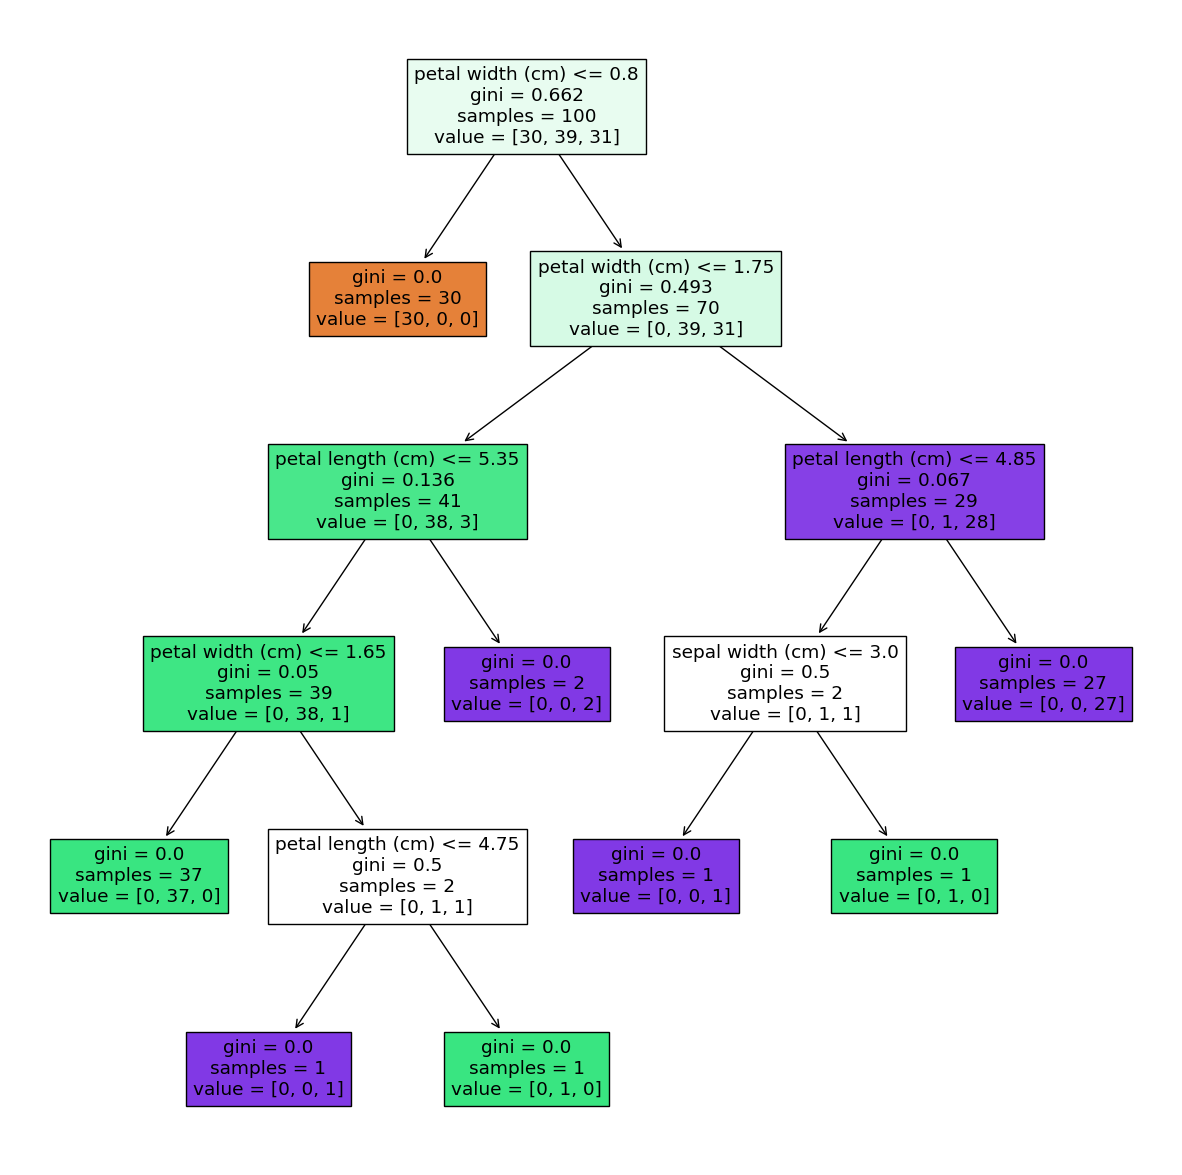

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
r=tree.plot_tree(dt, filled=True, feature_names=iris.feature_names)
plt.show()

#### Exercises
1. Check how a new instance with `x = [5.6, 3.0, 4.1, 1.3]` would classify. Follow the tree from the root to the leaves
2. Change the tree from Using Gini to using Entropy as a criterion, and check how the tree changes 
3. Change the tree setting min_samples_leaf=7 and check how the tree changes


[1]


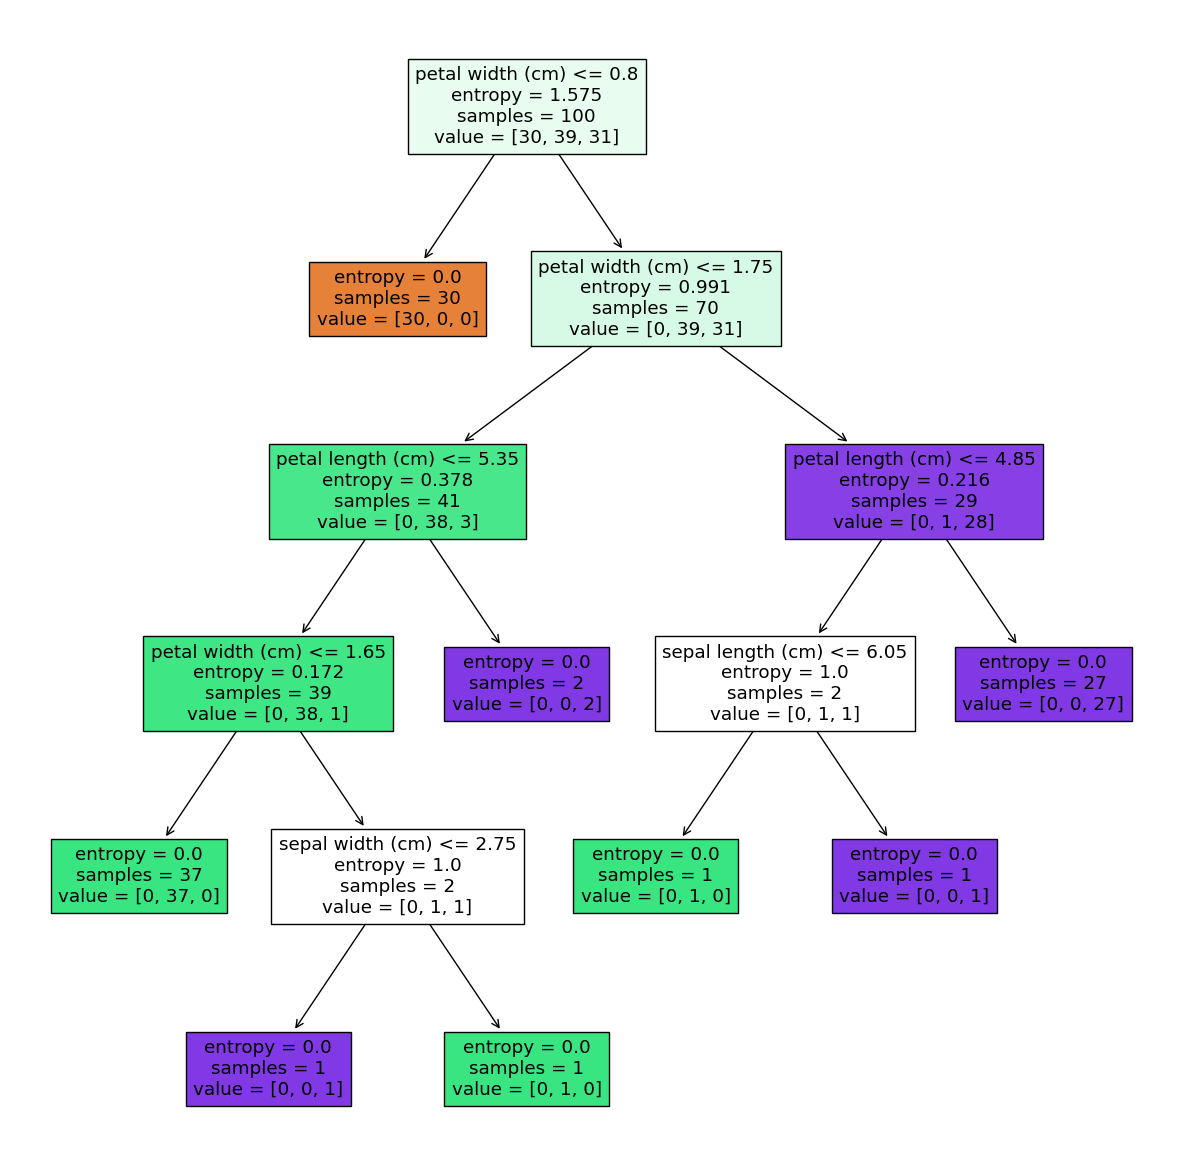

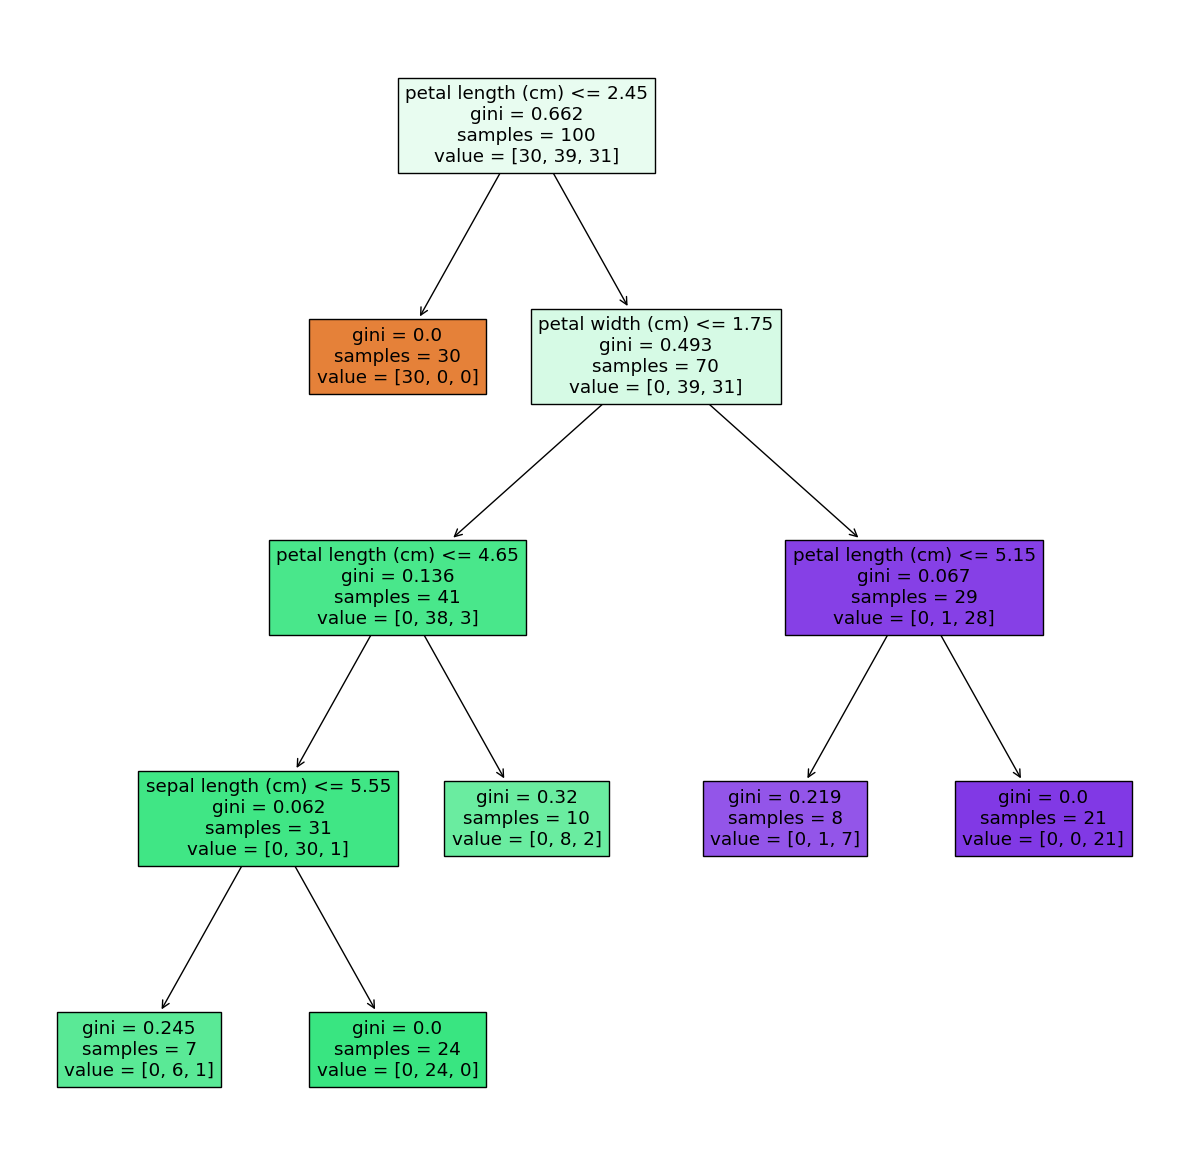

In [47]:
#your code here
from sklearn import tree
import matplotlib.pyplot as plt


x3 = [[5.6, 3.0, 4.1, 1.3]]
pre = dt.predict(x3)

print(pre)

entropia = tree.DecisionTreeClassifier(criterion='entropy')
entropia = entropia.fit(X_train, y_train)
plt.figure(figsize=(15,15))
r=tree.plot_tree(entropia, filled=True, feature_names=iris.feature_names)
plt.show()

minn = tree.DecisionTreeClassifier(min_samples_leaf=7)
minn = minn.fit(X_train, y_train)
plt.figure(figsize=(15,15))
r=tree.plot_tree(minn, filled=True, feature_names=iris.feature_names)
plt.show()

# x3 = [5.6, 3.0, 4.1, 1.3]
# X_train = np.append(X_train, x3)
# dt = tree.DecisionTreeClassifier()
# dt = dt.fit(X_train , y_train)


To evaluate this multiclass classifier we can use the classification report and the confusion matrix:

In [48]:
import pandas as pd
from sklearn.metrics import f1_score, classification_report, confusion_matrix, matthews_corrcoef
preds= dt.predict(X_test)

print(classification_report(y_test, preds))
pd.DataFrame(confusion_matrix(y_test, preds))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.85      1.00      0.92        11
           2       1.00      0.89      0.94        19

    accuracy                           0.96        50
   macro avg       0.95      0.96      0.95        50
weighted avg       0.97      0.96      0.96        50



,0,1,2
0,20,0,0
1,0,11,0
2,0,2,17


## 9 Decision Trees for regression (Extra - not evaluated - to be done in class if time allows)

We will use the diabetes dataset:

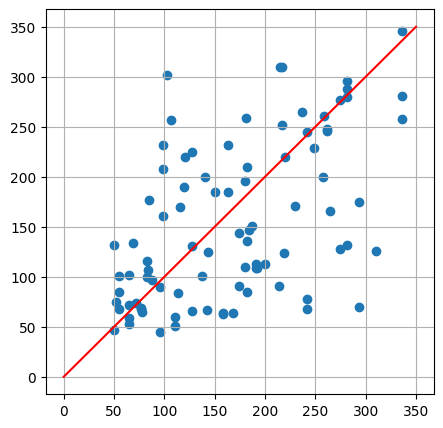

In [49]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np

X_diabetes, y_diabetes=load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.2)#, random_state=22)

rt = tree.DecisionTreeRegressor()
rt.fit(X_train, y_train)
preds=rt.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(preds, y_test)
plt.plot((0, 350), (0,350), c="r")
plt.grid()
plt.show()

#print("RVE: %7.4f"  % explained_variance_score(y_test, preds))
#print("rmse: %7.4f" % mean_squared_error(y_test, preds, squared=False))


#### Exercises

1. Comment on the results above. How would you explain these values, and what should you do to correct them?
2. Compare the times spent in inducing the regression tree and the classification tree. Comment the results
4. Make a plot showing how the mse changes as min_samples_leaf ranges from 1 to 40
5. Examine graphically the best tree identified and comment on your results


In [50]:
#Exercise 2 solution
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.2)#, random_state=22)
rt = tree.DecisionTreeRegressor()
%timeit rt.fit(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_diabetes, y_diabetes, test_size=0.2)#, random_state=22)
ct = tree.DecisionTreeClassifier()
%timeit ct.fit(X_train, y_train)

3.48 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.7 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


C:\Users\bakug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\bakug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\bakug\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea

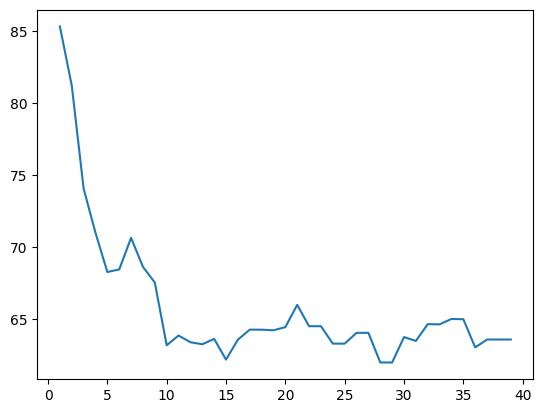

In [51]:
#Exercise 3. Solution
mses=[]
for i in range(1,40):
    rt = tree.DecisionTreeRegressor(min_samples_leaf=i)
    rt.fit(X_train, y_train)
    preds=rt.predict(X_test)
    mses.append( mean_squared_error(y_test, preds, squared=False))

plt.plot(range(1,40), mses)
plt.show()

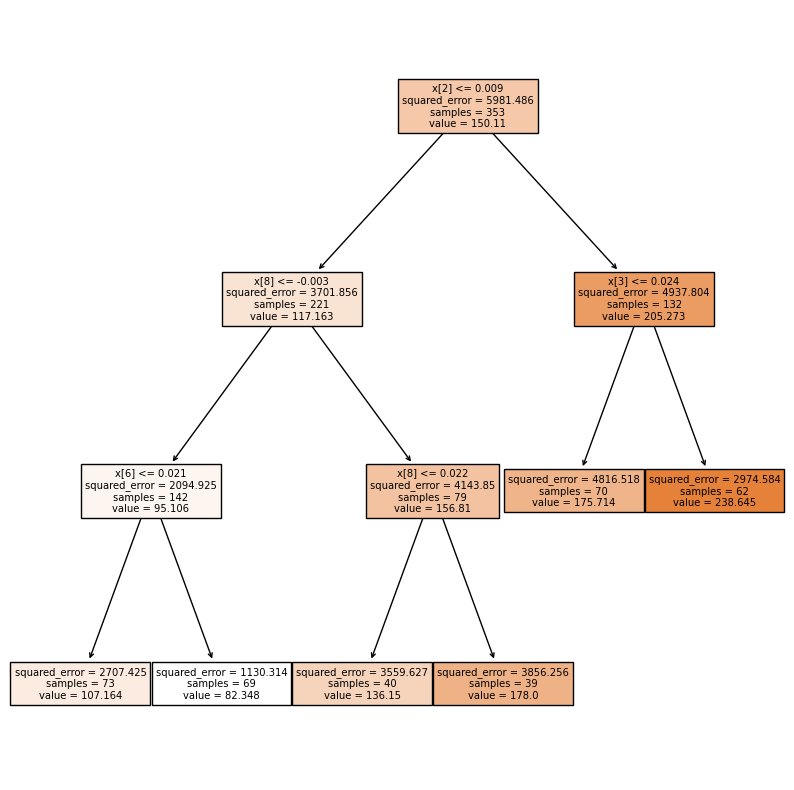

In [52]:
#exercise 4. solution
plt.figure(figsize=(10,10))
r=tree.plot_tree(rt, filled=True)
plt.show()